In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/students_data.csv')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
#feature selection for clustering
clustering_features = [
    'study_hours_per_day',
    'social_media_hours',
    'sleep_hours',
    'mental_health_rating',
    'time_management_score',
    'stress_level',
    'exam_anxiety_score',
    'motivation_level',
    'previous_gpa',
    'exam_score'
]

In [ ]:
df = data[clustering_features].copy()

In [ ]:
# standardize the data
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled_array, columns=clustering_features)

print(f"Shape of Scaled Feature Matrix (X_scaled): {df_scaled.shape}")


Shape of Scaled Feature Matrix (X_scaled): (80000, 10)


In [ ]:
# C. Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

# Convert the PCA results back to a DataFrame
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

df_pca['student_id'] = data['student_id']

print(f"Shape of PCA-Reduced Data: {df_pca.shape}")
print(f"Total Variance Explained by PC1 and PC2: {pca.explained_variance_ratio_.sum():.2f}")

Shape of PCA-Reduced Data: (80000, 3)
Total Variance Explained by PC1 and PC2: 0.40


Calculating inertia for Elbow Method (K=1 to 10)...


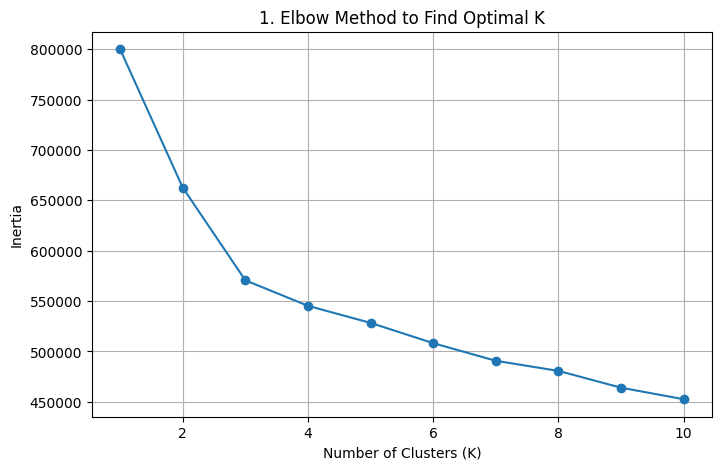

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia= []

print("Calculating inertia for Elbow Method (K=1 to 10)...")
for i in range(1,11):
    # Set n_init='auto' for safety and efficiency in modern scikit-learn
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11),inertia, marker='o', )
plt.title('1. Elbow Method to Find Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns

K_optimal = 4

# Fit the K-Means model with the optimal K
kmeans_final = KMeans(n_clusters=K_optimal, init='k-means++', random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(df_scaled)

# Add the cluster labels to the original data DataFrame
# We use 'data' because it contains all original features (student_id, etc.)
data['Cluster'] = cluster_labels

# Also add the labels to the PCA visualization DataFrame
df_pca['Cluster'] = cluster_labels

print("Cluster sizes:")
print(data['Cluster'].value_counts().sort_index())

Cluster sizes:
Cluster
0    19090
1    25840
2    15139
3    19931
Name: count, dtype: int64


In [ ]:
print("First 5 students with their assigned cluster labels:")
print(data[['student_id', 'exam_score', 'Cluster']].head())
print("-" * 50)

First 5 students with their assigned cluster labels:
   student_id  exam_score  Cluster
0      100000         100        2
1      100001          99        2
2      100002          98        1
3      100003         100        3
4      100004          98        3
--------------------------------------------------


In [ ]:
# Define the most important features for profiling, using UNSEALED data
profiling_features = [
    'exam_score',
    'previous_gpa',
    'study_hours_per_day',
    'social_media_hours',
    'sleep_hours',
    'time_management_score',
    'mental_health_rating',
    'stress_level',
]

# Group the data by the 'Cluster' column and calculate the mean for each feature
cluster_summary = data.groupby('Cluster')[profiling_features].mean()

print("## Study Profile Summary (Mean Values for Each Cluster)")
# Print the summary, formatted to two decimal places for readability
print(cluster_summary.applymap(lambda x: f'{x:.2f}'))

## Study Profile Summary (Mean Values for Each Cluster)
        exam_score previous_gpa study_hours_per_day social_media_hours  \
Cluster                                                                  
0            72.32         2.93                3.29               2.52   
1            94.24         3.82                4.25               2.49   
2            94.17         3.80                4.64               2.47   
3            94.82         3.83                4.56               2.51   

        sleep_hours time_management_score mental_health_rating stress_level  
Cluster                                                                      
0              6.78                  5.44                 6.84         5.38  
1              7.04                  5.52                 6.85         4.94  
2              7.11                  5.68                 5.20         6.22  
3              7.15                  5.40                 7.92         3.84  


/tmp/ipython-input-1349959290.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(cluster_summary.applymap(lambda x: f'{x:.2f}'))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


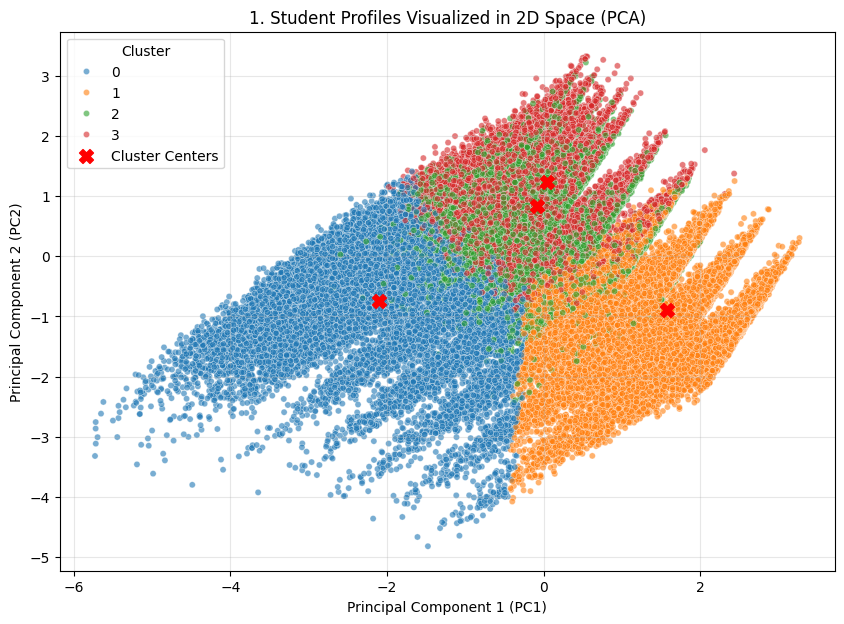

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

K_optimal = data['Cluster'].nunique()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=df_pca,
    palette=sns.color_palette('tab10', n_colors=K_optimal),
    legend='full',
    alpha=0.6,
    s=20
)

# Plot the cluster centers (projected onto the PCA space)
# Assuming 'kmeans_final' and 'pca' objects are still available
centers = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=100, color='red', label='Cluster Centers', zorder=10)

plt.title(f'1. Student Profiles Visualized in 2D Space (PCA)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

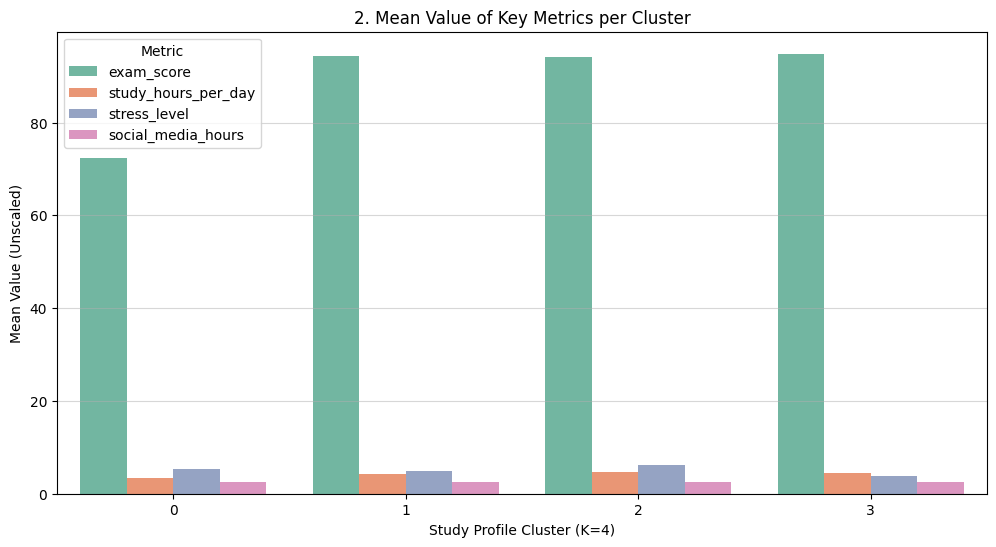

In [ ]:
# Group the original (unscaled) data by cluster
cluster_means = data.groupby('Cluster')[[
    'exam_score',
    'study_hours_per_day',
    'stress_level',
    'social_media_hours'
]].mean().reset_index()

# Melt the DataFrame for easy plotting with Seaborn
df_melted = cluster_means.melt(
    id_vars='Cluster',
    var_name='Metric',
    value_name='Mean Value'
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Cluster',
    y='Mean Value',
    hue='Metric',
    data=df_melted,
    palette='Set2'
)

plt.title('2. Mean Value of Key Metrics per Cluster')
plt.xlabel(f'Study Profile Cluster (K={K_optimal})')
plt.ylabel('Mean Value (Unscaled)')
plt.legend(title='Metric')
plt.grid(axis='y', alpha=0.5)
plt.show()

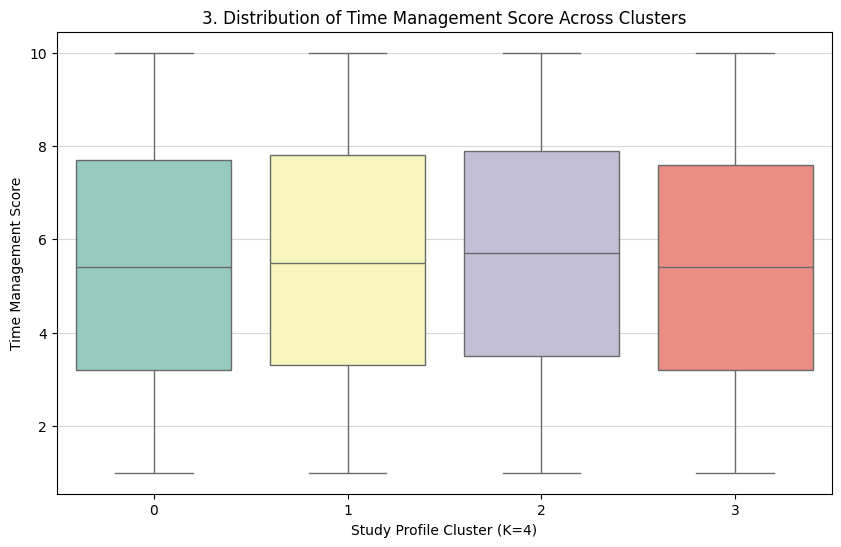

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Cluster',
    y='time_management_score',
    data=data,
    palette='Set3',
    hue='Cluster',
    legend=False
)

plt.title('3. Distribution of Time Management Score Across Clusters')
plt.xlabel(f'Study Profile Cluster (K={K_optimal})')
plt.ylabel('Time Management Score')
plt.grid(axis='y', alpha=0.5)
plt.show()

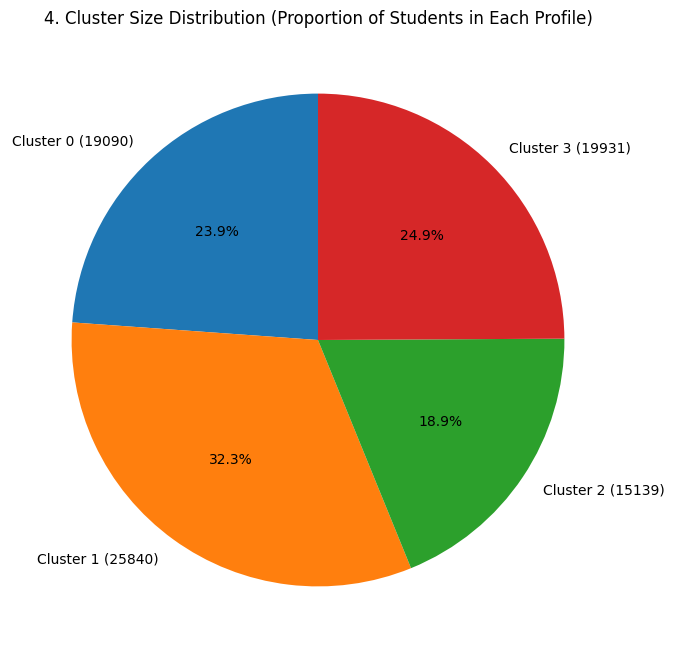

In [ ]:
plt.figure(figsize=(8, 8))
# Use Matplotlib's pie chart for clear proportion display
cluster_counts = data['Cluster'].value_counts().sort_index()
labels = [f'Cluster {i} ({count})' for i, count in cluster_counts.items()]

plt.pie(
    cluster_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('tab10', n_colors=K_optimal)
)

plt.title('4. Cluster Size Distribution (Proportion of Students in Each Profile)')
plt.show()

In [ ]:
cluster_summary = data.groupby('Cluster')[clustering_features].mean()

# --- Print the Summary ---
print("## Study Profile Summary: Mean Values for Each Cluster")
print("-------------------------------------------------------")

# Print the summary, formatted to two decimal places for clear readability
print(cluster_summary.applymap(lambda x: f'{x:.2f}'))

## Study Profile Summary: Mean Values for Each Cluster
-------------------------------------------------------
        study_hours_per_day social_media_hours sleep_hours  \
Cluster                                                      
0                      3.29               2.52        6.78   
1                      4.25               2.49        7.04   
2                      4.64               2.47        7.11   
3                      4.56               2.51        7.15   

        mental_health_rating time_management_score stress_level  \
Cluster                                                           
0                       6.84                  5.44         5.38   
1                       6.85                  5.52         4.94   
2                       5.20                  5.68         6.22   
3                       7.92                  5.40         3.84   

        exam_anxiety_score motivation_level previous_gpa exam_score  
Cluster                                    

/tmp/ipython-input-3629554349.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(cluster_summary.applymap(lambda x: f'{x:.2f}'))
